# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [115]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import cv2
import random
import pandas as pd
from copy import copy
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from scipy import ndimage

%matplotlib inline

CHANNELS = 1
EPOCHS = 100
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
L2_BETA = 0.001
KEEP_PROB = 0.75
NUM_CLASSES = 43

In [116]:
training_file = 'Data/train.p'
validation_file = 'Data/valid.p'
testing_file = 'Data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print (X_train.shape)
print (X_validation.shape)
print (X_test.shape)

del training_file, validation_file, testing_file

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [120]:
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of training examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of training examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


---

## Preprocessing Dataset

In order to most effectively train my network, I'm going to do some preprocessing. I'll include these preprocessing steps in my exploratory visualization of the dataset.

Below is the method I use to preprocess my dataset. This preprocessing adjusts the brightness of the pixels to normalize the histogram of pixel brightness values using OpenCV's `equalizeHist` function. This helps normalize the images' brightness throughout the dataset, and improve image contrast.

In [118]:
def preprocess_image(image, channels = CHANNELS, scale_range = True):
    """
    Preprocess an image for analysis. Expects an YxYx3 dimensional
    image as the first parameter, returns an YxYxchannels dimensional
    image.

    Keyword arguments:
    channels -- the number of channels of the image to return
    scale_range -- scale the image pixels to -0.5-0.5 after processing
    """
    assert channels == 3 or channels == 1, "channels parameter must be 1 or 3" % id
    adjusted_image = copy(image)
        
    # Equalize the pixel histograms of each color channel using OpenCV's equalizeHist. This has the
    # effect of normalizing the brightness and contrast of each image.
    for channel in range(3):
        adjusted_image[:,:,channel] = cv2.equalizeHist(adjusted_image[:,:,channel])
        
    if scale_range is False:
        return adjusted_image

    # Scale image brightness values from 0 to 255 to -0.5 to 0.5
    if channels == 3:
        adjusted_image = adjusted_image / 255. - 0.5
    else:
        adjusted_image = cv2.cvtColor(adjusted_image, cv2.COLOR_RGB2GRAY)
        adjusted_image = (adjusted_image / 255. - 0.5)[:,:,None]
        
    return adjusted_image

## Visualize Preprocessing

Visualize the effects of preprocessing on the dataset.

The three histogram plots show a histogram of the pixel brightness values in the image. The first row is an unmodified image. The second row is the same image after applying OpenCV's `equalizeHist` function. The third row is the result of scaling the intermediate value so that the pixel values all fall between -0.5 and 0.5 instead of 0 to 255.

Finally, a before and after image is shown of the subject image.

Preprocessing for image 25616


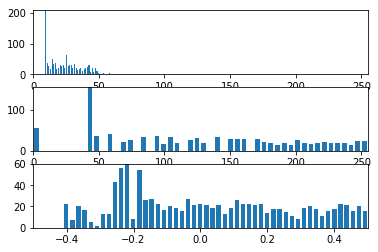

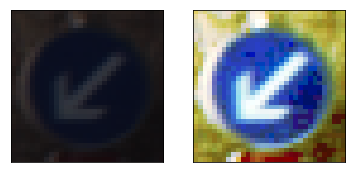

In [119]:
## Uncomment to select a random image. For submitting the notebook, I have selected
## an image for which preprocessing helps a lot.
# [index] = random.sample(range(X_train.shape[0]), 1)
index = 25616

print("Preprocessing for image", index)

fig = plt.figure()

image_transforms = [
    lambda image: image[:,:,0],
    lambda image: cv2.equalizeHist(image[:,:,0]),
    lambda image: preprocess_image(image)[:,:,0]
]
subplots = [311, 312, 313]
ranges = [ [0, 255], [0, 255], [-0.5, 0.5] ]

for (image_transform, subplot, x_range) in zip(image_transforms, subplots, ranges):
    image = image_transform(copy(X_train[index]))
    ax = fig.add_subplot(subplot)
    hist, bins = np.histogram(image, bins=50)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    ax.set_xlim(x_range)
    ax.set_ylim(0, np.max(hist))

fig = plt.figure()

ax1 = fig.add_subplot(121, xticks=[], yticks=[])
ax1.imshow(X_train[index])
ax2 = fig.add_subplot(122, xticks=[], yticks=[])
ax2.imshow(preprocess_image(X_train[index], channels = 1, scale_range = False))

plt.show()

## Preprocess Dataset

Apply our preprocessing to the entire dataset. We also convert the `y` values to one-hot-encoded values.

In [101]:
X_train_processed = np.array([ preprocess_image(x) for x in X_train ])
y_train_one_hot = np.eye(NUM_CLASSES)[y_train]
X_validation_processed = np.array([ preprocess_image(x) for x in X_validation ])
y_validation_one_hot = np.eye(NUM_CLASSES)[y_validation]
X_test_processed = np.array([ preprocess_image(x) for x in X_test ])
y_test_one_hot = np.eye(NUM_CLASSES)[y_test]

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

The first figure in the below visualizations shows the frequency of each of the sign types in the dataset. As can be seen from this histogram, the dataset is not balanced; in other words, some signs appear much more than others. One way to improve our trained model would be to artificially balance the dataset, removing potential bias that would exist from an unbalanced dataset.

The images below show 15 random samples from each sign type, both before and after preprocessing. In each row corresponding to sign type, we show the human-readable sign type description and the number of these signs that appear in the dataset.

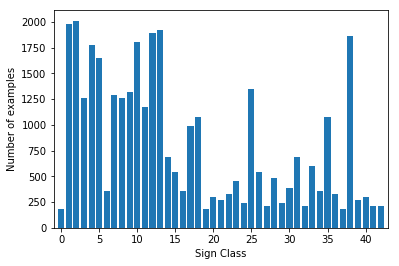

Speed limit (20km/h) (180 objects)


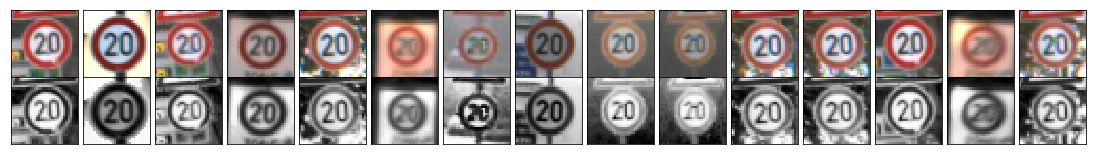

Speed limit (30km/h) (1980 objects)


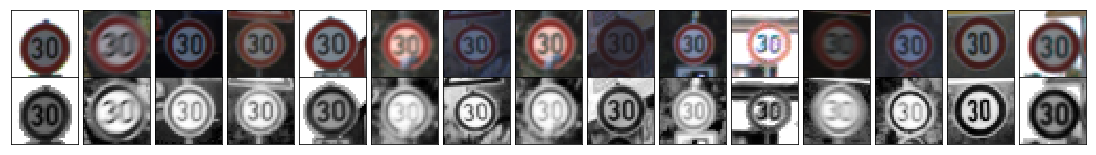

Speed limit (50km/h) (2010 objects)


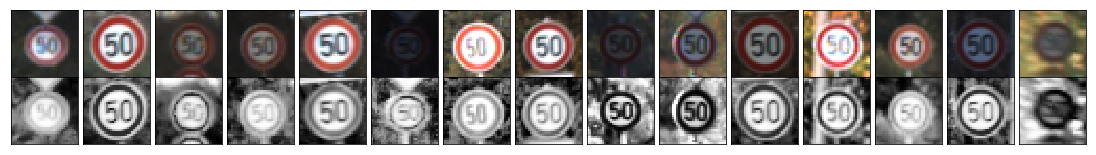

Speed limit (60km/h) (1260 objects)


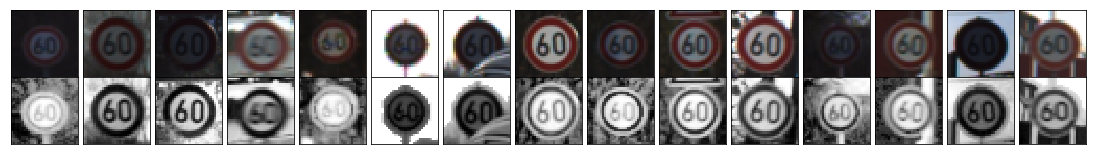

Speed limit (70km/h) (1770 objects)


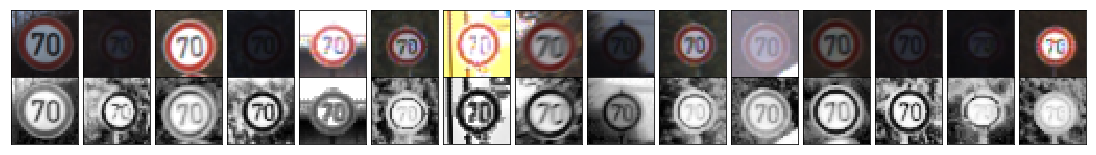

Speed limit (80km/h) (1650 objects)


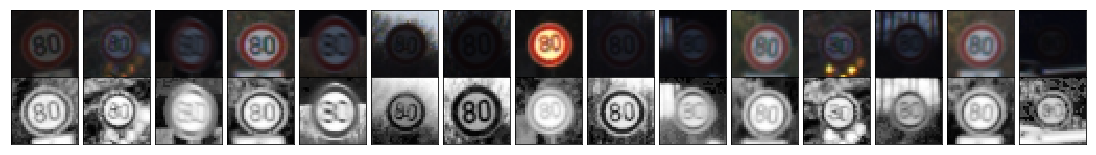

End of speed limit (80km/h) (360 objects)


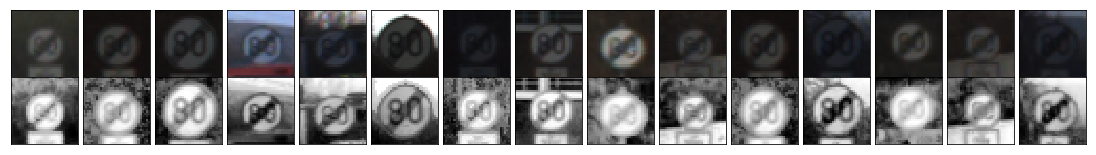

Speed limit (100km/h) (1290 objects)


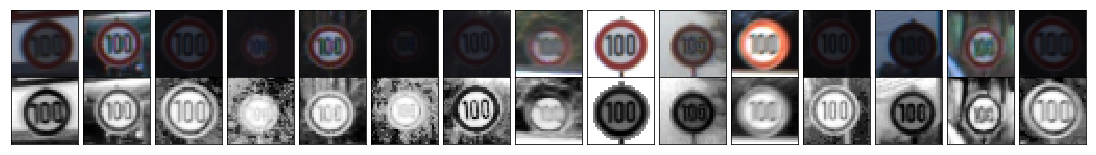

Speed limit (120km/h) (1260 objects)


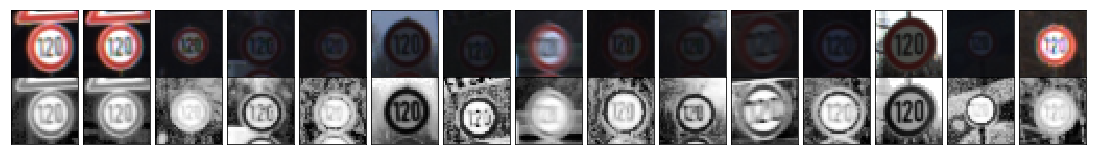

No passing (1320 objects)


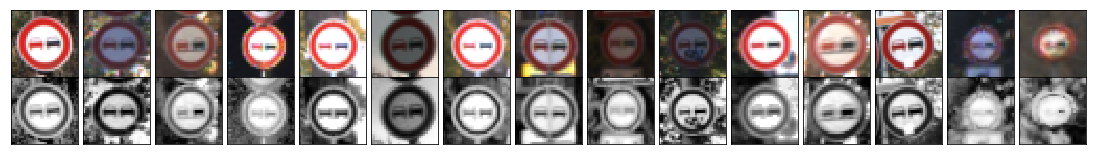

No passing for vehicles over 3.5 metric tons (1800 objects)


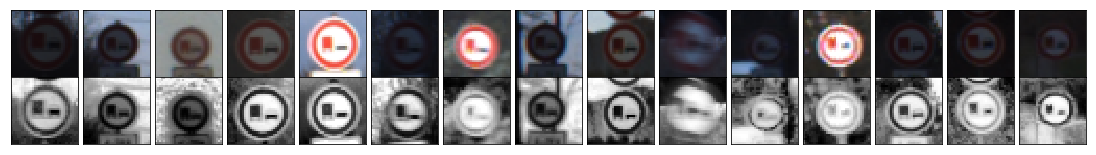

Right-of-way at the next intersection (1170 objects)


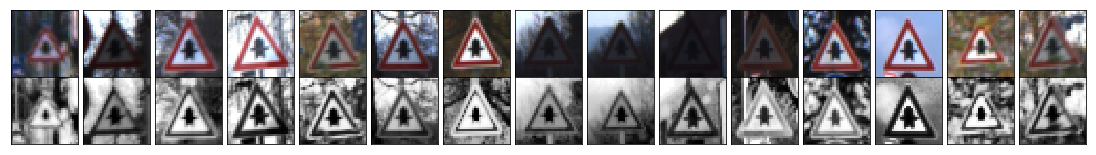

Priority road (1890 objects)


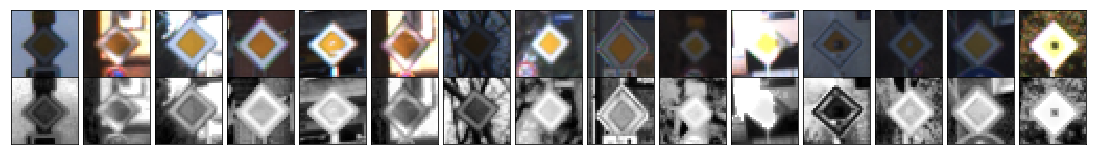

Yield (1920 objects)


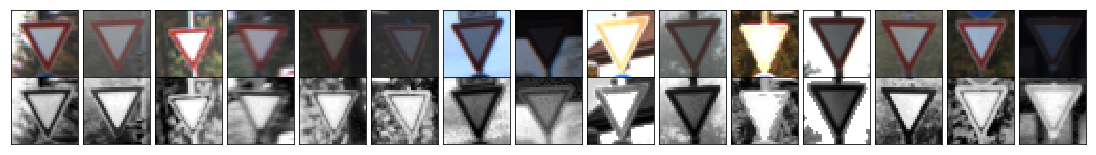

Stop (690 objects)


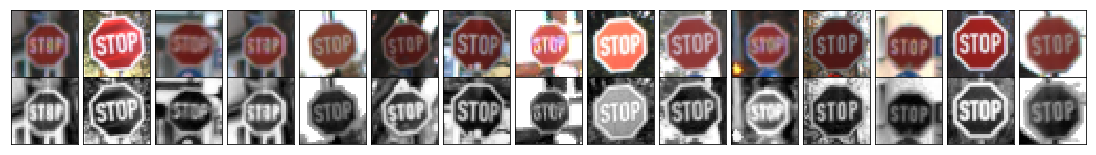

No vehicles (540 objects)


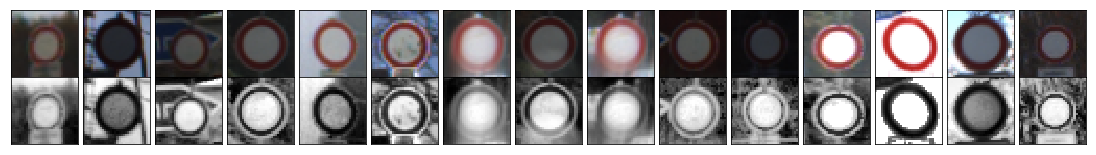

Vehicles over 3.5 metric tons prohibited (360 objects)


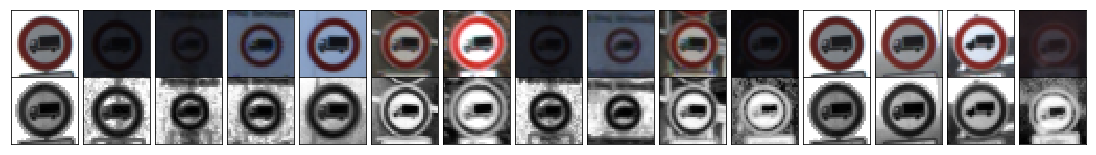

No entry (990 objects)


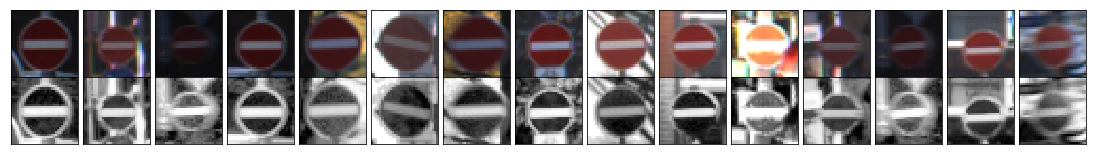

General caution (1080 objects)


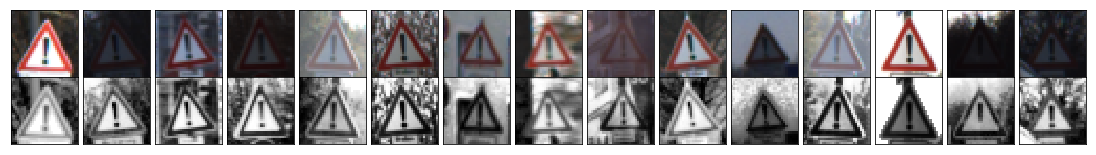

Dangerous curve to the left (180 objects)


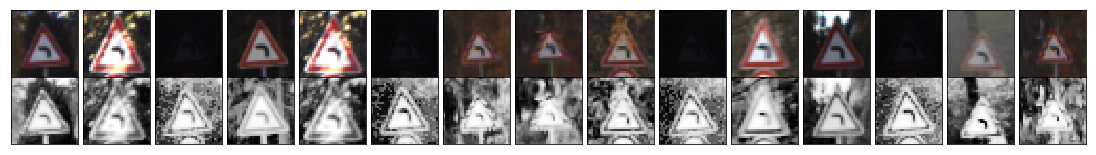

Dangerous curve to the right (300 objects)


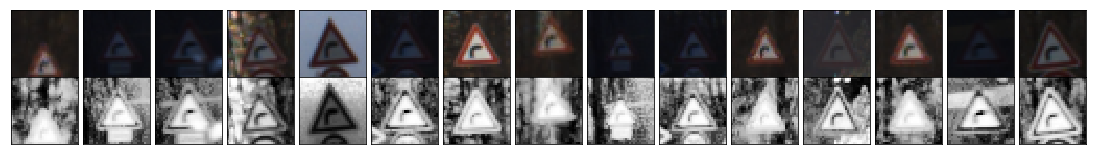

Double curve (270 objects)


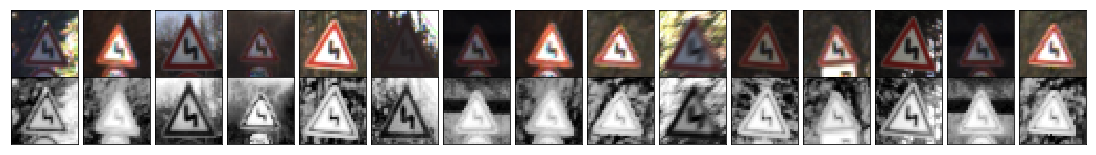

Bumpy road (330 objects)


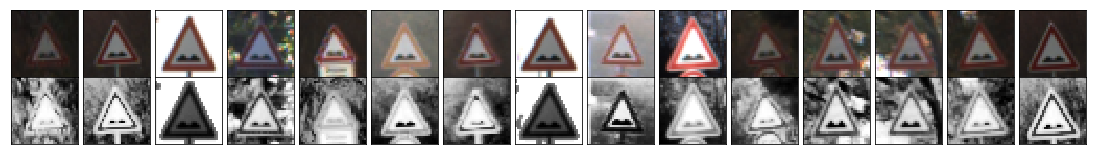

Slippery road (450 objects)


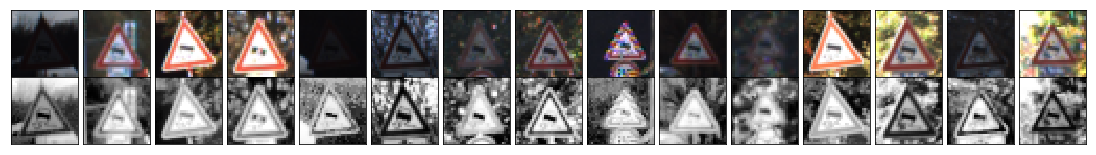

Road narrows on the right (240 objects)


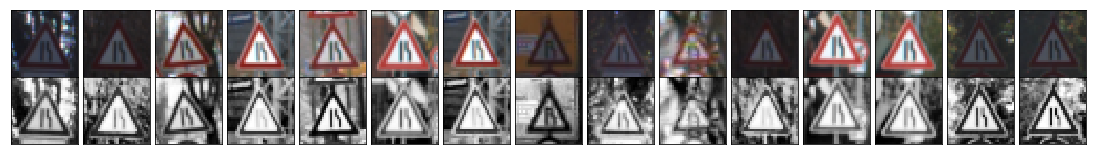

Road work (1350 objects)


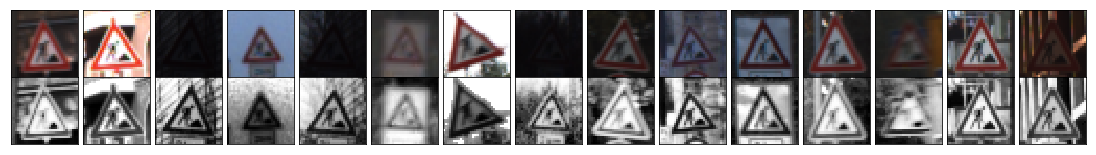

Traffic signals (540 objects)


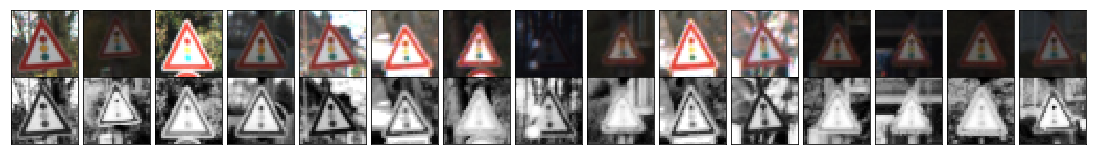

Pedestrians (210 objects)


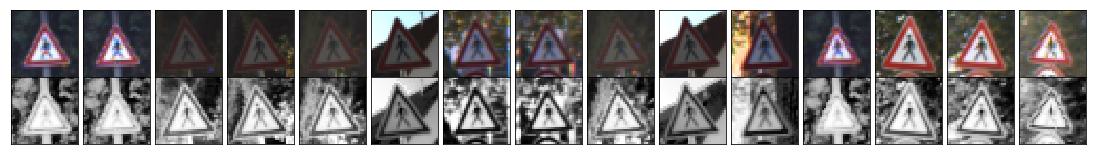

Children crossing (480 objects)


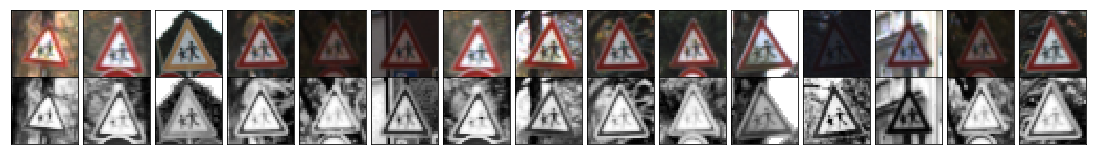

Bicycles crossing (240 objects)


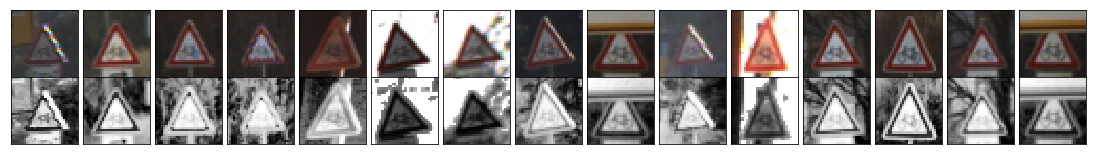

Beware of ice/snow (390 objects)


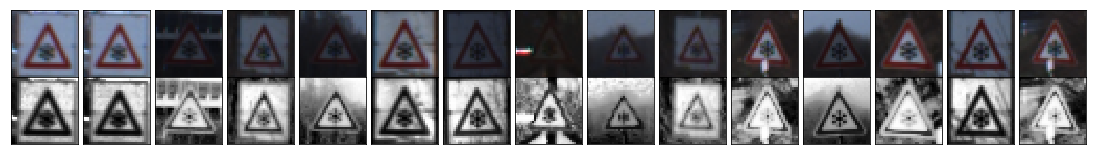

Wild animals crossing (690 objects)


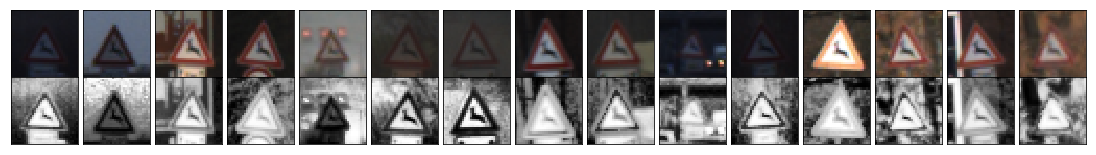

End of all speed and passing limits (210 objects)


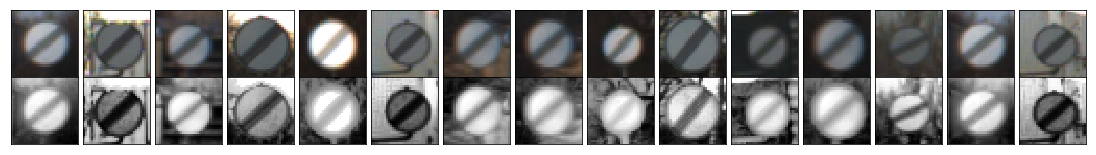

Turn right ahead (599 objects)


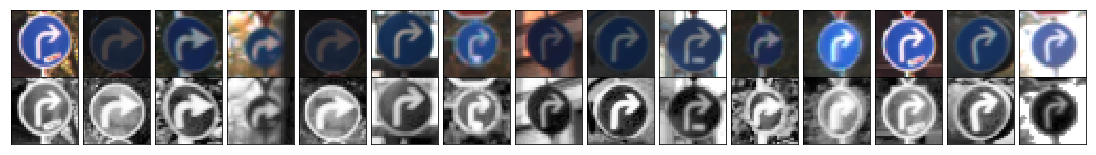

Turn left ahead (360 objects)


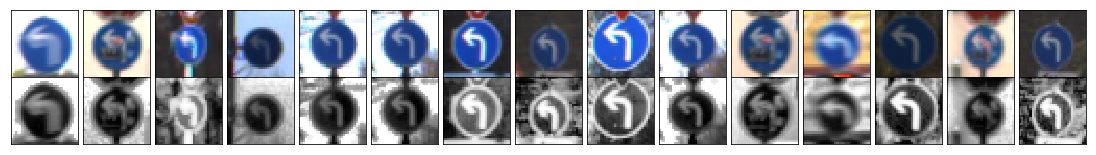

Ahead only (1080 objects)


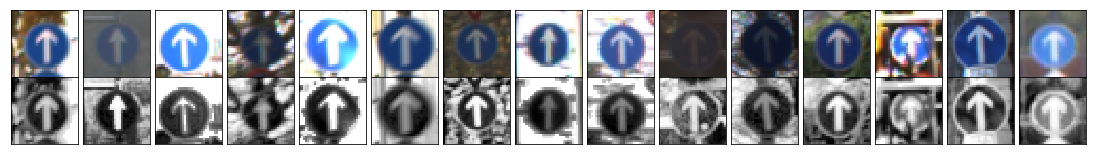

Go straight or right (330 objects)


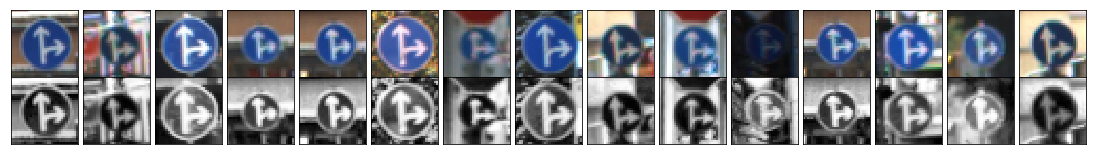

Go straight or left (180 objects)


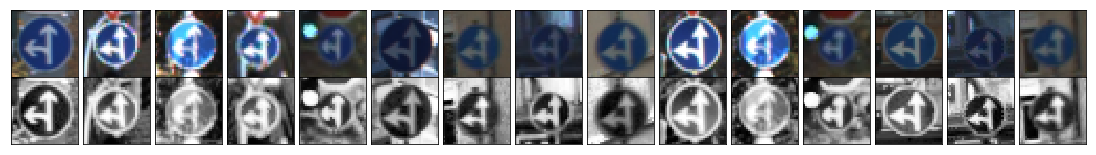

Keep right (1860 objects)


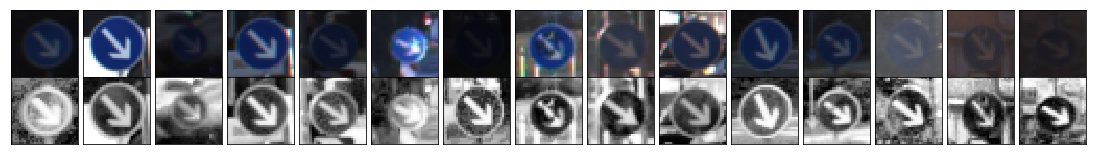

Keep left (270 objects)


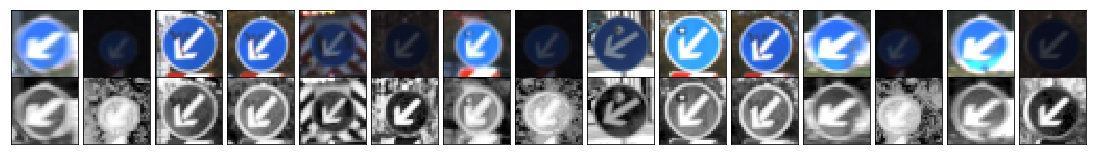

Roundabout mandatory (300 objects)


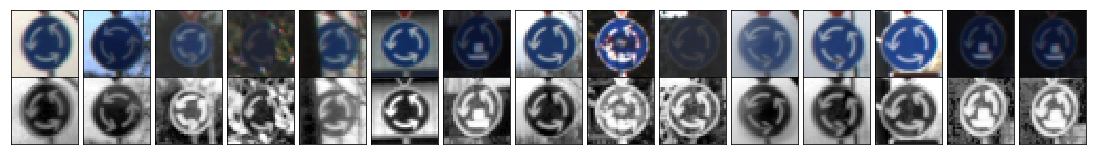

End of no passing (210 objects)


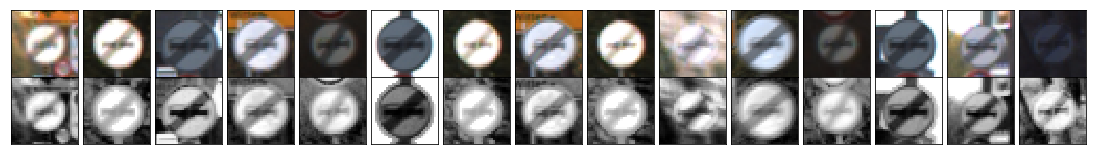

End of no passing by vehicles over 3.5 metric tons (210 objects)


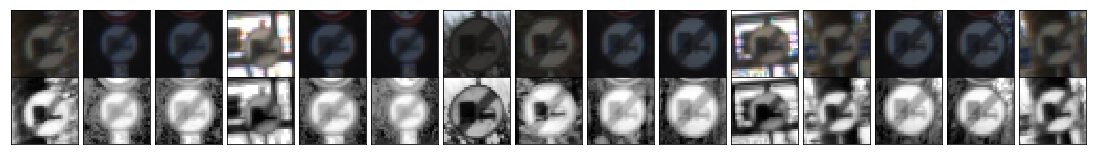

In [109]:
sign_names = list(pd.read_csv('signnames.csv').SignName)

def show_image(axis, img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        axis.imshow(img)
    else:
        axis.imshow(img[:,:,0], cmap='gray')

sign_classes, sign_counts = np.unique(y_train, return_counts = True)
plt.bar(np.arange(NUM_CLASSES), sign_counts, align='center')
plt.xlabel('Sign Class')
plt.ylabel('Number of examples')
plt.xlim([-1, 43])
plt.show()

for sign_index in np.arange(NUM_CLASSES):
    indexes = random.sample(list(np.where(y_train_one_hot[:, sign_index] == 1)[0]), 15)
    print("%s (%d objects)" % (sign_names[sign_index], sign_counts[sign_index]))
    fi0.142857143g = plt.figure(figsize = (15, 40))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.0, wspace = 0.0)
    for (i, index) in enumerate(indexes):
        axis = fig.add_subplot(NUM_CLASSES, 15, i + 1, xticks=[], yticks=[])
        show_image(axis, X_train[index])
        axis = fig.add_subplot(NUM_CLASSES, 15, 15 + i + 1, xticks=[], yticks=[])
        show_image(axis, X_train_processed[index])
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

This first code block defines some helper methods used to more quickly create layers of a neural network, like convolutional layers, max pooling layers, and fully connected layers. Uses Xavier initialization to prevent near-zero initial conditions that get the network stuck. See https://youtu.be/gYpoJMlgyXA?t=36m52s for discussion.

In [8]:
def conv_layer(x, filter_size, stride, padding = 'SAME', activate = True):
    # Naming our weights variables will allow us to more easily apply regularization
    # by minimizing the value of our weights, by adding a term to our loss function
    # that includes a contribution from the magnitude of the weights.    
    weights = tf.get_variable('weights',
        shape = filter_size,
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
    )
    bias = tf.get_variable('bias', 
       shape = [filter_size[3]],
       initializer = tf.constant_initializer(0.0)
    )
    conv = tf.nn.conv2d(x, weights, strides=[1, stride, stride, 1], padding = padding) + bias
    if activate:
        # Naming this variable 'activation' will help us extract these values
        # to inspect the feature map activation values later.
        conv = tf.tanh(conv, name = 'activation')
    return conv

def pool_layer(x, k_size, stride, padding = 'VALID'):
    return tf.nn.max_pool(x, 
        ksize = [1, k_size, k_size, 1], 
        strides = [1, stride, stride, 1], 
        padding = padding
    )

def fully_connected_layer(x, in_size, out_size, activate = True):
    weights = tf.get_variable('weights',
        shape = [in_size, out_size],
        initializer = tf.contrib.layers.xavier_initializer()
    )
    bias = tf.get_variable('bias', 
       shape = [out_size],
       initializer = tf.constant_initializer(0.0)
    )
    fc = tf.matmul(x, weights) + bias
    if activate:
        fc = tf.tanh(fc)
    return fc

The function below defines our architecture. It is very similar to the LeNet architecture described in our lessons, with more convolutional features in the convolutional steps, and more fully connected nodes in the fully connected layers.

In [9]:
def model_pass(x, keep_prob, channels = CHANNELS):  
    with tf.variable_scope('conv1'):
        # 32x32x3 => 28x28x128
        conv1 = conv_layer(x, filter_size = (5, 5, channels, 128), stride = 1, padding = 'VALID')
        # 28x28x128 => 14x14x128
        conv1 = pool_layer(conv1, k_size = 2, stride = 2)
    
    with tf.variable_scope('conv2'):
        # 14x14x128 => 10x10x256
        conv2 = conv_layer(conv1, filter_size = (5, 5, 128, 256), stride = 1, padding = 'VALID')
        # 10x10x256 => 5x5x256
        conv2 = pool_layer(conv2, k_size = 2, stride = 2)
        
    # 5x5x256 => 6,400 flattened => 120
    with tf.variable_scope('fc1'):
        fc1 = fully_connected_layer(flatten(conv2), 6400, 120)
        fc1 = tf.nn.dropout(fc1, keep_prob)
    # 120 => 84
    with tf.variable_scope('fc2'):
        fc2 = fully_connected_layer(fc1, 120, 84)
        fc2 = tf.nn.dropout(fc2, keep_prob)
    # 84 => NUM_CLASSES
    with tf.variable_scope('logits'):
        logits = fully_connected_layer(fc2, 84, NUM_CLASSES)

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In addition to reporting the training, validation, and testing accuraacy and loss of the trained model, I plot the training and validation accuracy and loss over time, to see how the values change with epoch.

In [16]:
class TimeExecution():
    '''
    A class to time execution of a code block.
    '''
    from datetime import datetime
    def __enter__(self):
        self.start = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('Runtime: {}'.format(self.datetime.now() - self.start))

with TimeExecution():    
    graph = tf.Graph()
    with graph.as_default():
        X_train, y_train = shuffle(X_train_processed, y_train_one_hot)
        tensorflow_X = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
        tensorflow_y = tf.placeholder(tf.float32, (None, NUM_CLASSES))
        keep_prob = tf.placeholder(tf.float32)

        logits = model_pass(tensorflow_X, keep_prob, channels = CHANNELS)

        l2_loss = 0
        with tf.variable_scope('fc1', reuse = True):
            l2_loss += tf.nn.l2_loss(tf.get_variable('weights'))
        with tf.variable_scope('fc2', reuse = True):
            l2_loss += tf.nn.l2_loss(tf.get_variable('weights'))

        predictions = tf.nn.softmax(logits)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tensorflow_y)
        loss = tf.reduce_mean(cross_entropy) + L2_BETA * l2_loss

        optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE).minimize(loss)

    with tf.Session(graph = graph, config = tf.ConfigProto(log_device_placement = True)) as session:
        saver = tf.train.Saver()
        session.run(tf.global_variables_initializer())

        def evaluate_accuracy_and_loss(X, y):
            prediction_results = []
            cross_entropy_results = []
            num_examples = len(X)
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_X, batch_y = X[offset : offset + BATCH_SIZE], y[offset : offset + BATCH_SIZE]
                [prediction_batch, cross_entropy_batch] = session.run([predictions, cross_entropy], feed_dict = {
                    tensorflow_X: batch_X, 
                    tensorflow_y: batch_y,
                    keep_prob: 1.0
                })
                prediction_results.extend(prediction_batch)
                cross_entropy_results.extend(cross_entropy_batch)
            prediction_results = np.array(prediction_results)
            cross_entropy_results = np.array(cross_entropy_results)        
            accuracy = np.sum(np.argmax(prediction_results, 1) == np.argmax(y, 1)) / prediction_results.shape[0]
            loss = np.mean(cross_entropy_results)        
            return (accuracy, loss)

        num_examples = len(X_train)

        epochs = range(EPOCHS)
        training_losses = []
        training_accuracies = []
        validation_losses = []
        validation_accuracies = []

        print("Training...", end="\n")
        for i in range(EPOCHS):
            X_train_processed, y_train_one_hot = shuffle(X_train_processed, y_train_one_hot)
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_X = X_train_processed[offset : offset + BATCH_SIZE]
                batch_y = y_train_one_hot[offset : offset + BATCH_SIZE]
                session.run([optimizer], feed_dict = {
                    tensorflow_X: batch_X,
                    tensorflow_y: batch_y,
                    keep_prob: KEEP_PROB
                })

            training_accuracy, training_loss = evaluate_accuracy_and_loss(X_train_processed, y_train_one_hot)
            validation_accuracy, validation_loss = evaluate_accuracy_and_loss(X_validation_processed, y_validation_one_hot)

            training_losses.append(training_loss)
            training_accuracies.append(training_accuracy)
            validation_losses.append(validation_loss)
            validation_accuracies.append(validation_accuracy)
            print("Epoch {}".format(i + 1), "Train {:.3f}".format(training_accuracy), "Validate {:.3f}".format(validation_accuracy), end="\r")

        print("Finished Epoch {}".format(i + 1), "Train {:.3f}".format(training_accuracy), "Validate {:.3f}".format(validation_accuracy), end="\n")
        saver.save(session, './traffic-signs')

Training...
Finished Epoch 100 Train 0.994 Validate 0.973
Runtime: 0:10:24.734869


## Plot Results

Test Accuracy: 0.955 Test Loss: 2.007


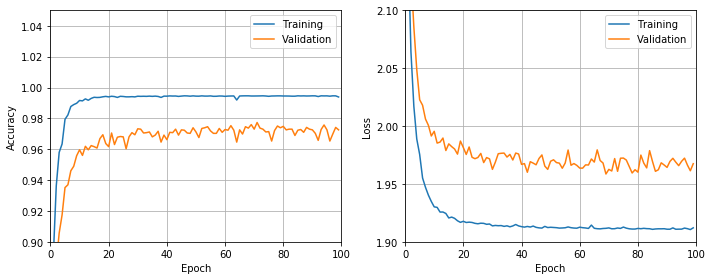

In [110]:
graph = tf.Graph()
with graph.as_default():
    X_train, y_train = shuffle(X_train_processed, y_train_one_hot)
    tensorflow_X = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
    tensorflow_y = tf.placeholder(tf.float32, (None, NUM_CLASSES))
    keep_prob = tf.placeholder(tf.float32)

    logits = model_pass(tensorflow_X, keep_prob, channels = CHANNELS)

    predictions = tf.nn.softmax(logits)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tensorflow_y)

    with tf.Session(graph = graph, config = tf.ConfigProto(log_device_placement = True)) as session:

        tf.train.Saver().restore(session, './traffic-signs')

        results_figure = plt.figure(figsize = (10, 4))
        
        axis = results_figure.add_subplot(1, 2, 1)
        plt.plot(epochs, training_accuracies, label='Training')        
        plt.plot(epochs, validation_accuracies, label='Validation')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.ylim(0.9, 1.05)
        plt.xlim(0, EPOCHS)
        plt.legend()
        plt.grid()

        axis = results_figure.add_subplot(1, 2, 2)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        axis.set_yticks(np.arange(1.9,2.1,0.05))
        plt.ylim(1.9, 2.1)
        plt.xlim(0, EPOCHS)
        plt.plot(epochs, training_losses, label='Training')
        plt.plot(epochs, validation_losses, label='Validation')
        axis.legend()
        axis.grid()        

        test_accuracy, test_loss = evaluate_accuracy_and_loss(X_test_processed, y_test_one_hot)

        plt.tight_layout()
        print("Test Accuracy: {:.3f}".format(test_accuracy), "Test Loss: {:.3f}".format(test_loss), end="\n")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

Signs came from http://finde-das-bild.de/bildersuche?page=1&keys=verkehrsschild and were resized to be 32x32x3.

Plotted image shows original image and preprocessed image for each of 5 images.

### Load and Output the Images

Shape of Internet images: (5, 32, 32, 3)


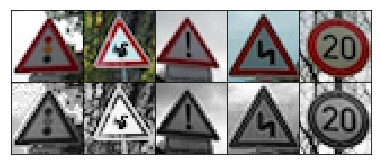

In [111]:
paths = [ 'Data/internet_data/{}.jpg'.format(x) for x in range(1,6) ]
X_internet = np.array([ ndimage.imread(path) for path in paths ])
X_internet_processed = np.array([ preprocess_image(x) for x in X_internet ])
print("Shape of Internet images: {}".format(X_internet.shape))

fig = plt.figure(figsize = (5, 2))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.0, wspace = 0.0)
for index in range(len(paths)):
    axis = fig.add_subplot(2, 5, index + 1, xticks=[], yticks=[])
    show_image(axis, X_internet[index])
    axis = fig.add_subplot(2, 5, 5 + index + 1, xticks=[], yticks=[])
    show_image(axis, X_internet_processed[index])
plt.show()

### Predict the Sign Type for Each Image

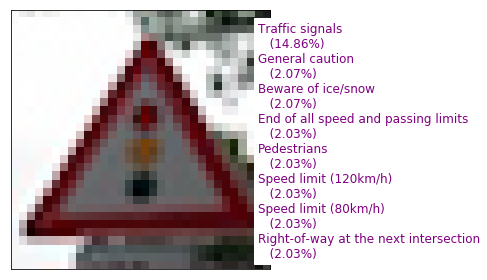

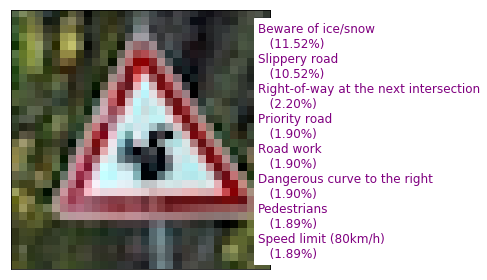

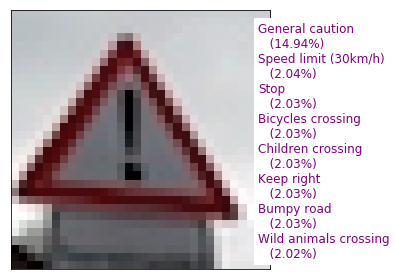

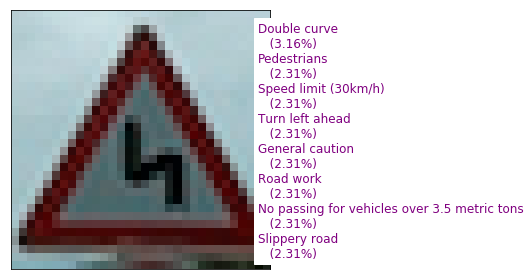

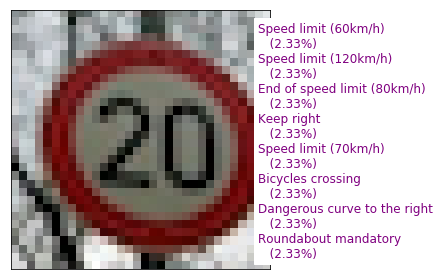

In [113]:
graph = tf.Graph()
with graph.as_default():
    tf_x = tf.placeholder(tf.float32, shape = (None, 32, 32, CHANNELS))
    keep_prob = tf.placeholder(tf.float32)
    predictions = tf.nn.softmax(model_pass(tf_x, keep_prob, channels = CHANNELS))
    top_k_predictions = tf.nn.top_k(predictions, 8)

with tf.Session(graph = graph) as session:
    tf.train.Saver().restore(session, './traffic-signs')
    [p] = session.run([top_k_predictions], feed_dict = {
            tf_x: X_internet_processed,
            keep_prob: 1.0
        }
    )

sign_names = list(pd.read_csv('signnames.csv').SignName)
for idx in range(len(p.values)):
    fig = plt.figure()
    plt.subplot(xticks=[], yticks=[])
    plt.imshow(X_internet[idx])
    prediction_strings = [ "{}\n   ({:.2f}%)".format(sign_names[x], 100 * p) for x,p in zip(p.indices[idx], p.values[idx]) ]
    annotation = "\n".join(prediction_strings)
    plt.text(30, 30, annotation, fontsize=12, color='purple', backgroundcolor='white')
    plt.tight_layout()

### Analyze Performance

Since I only have 5 Internet images, I am simply doing the math by hand. My classifier got 3/5 images correct. One image (duck crossing, I believe) doesn't actually correspond to a sign in my dataset, and so my model got 3/4 images correct for the images that existed in my dataset. This means the accuracy is either 60% or 75%, depending on how we decide to handle sign types that don't exist in one of the 43 classes in the training dataset.

Surprisingly (because my model overall has a high accuracy and this particular image is a very clear one), my model got the 20 km/h sign wrong. All its predictions were tied for a very low probability, but not even the top 8 included the 20 km/h sign class. One possible explanation is that the 20 km/h sign class is very under-represented in our training set (there are 7x as many 120 km/h signs, for example).

## Step 4: Visualize the Neural Network's State with Test Images

This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the LeNet lab's feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper End-to-End Deep Learning for Self-Driving Cars in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

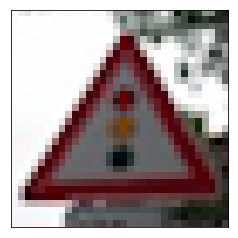

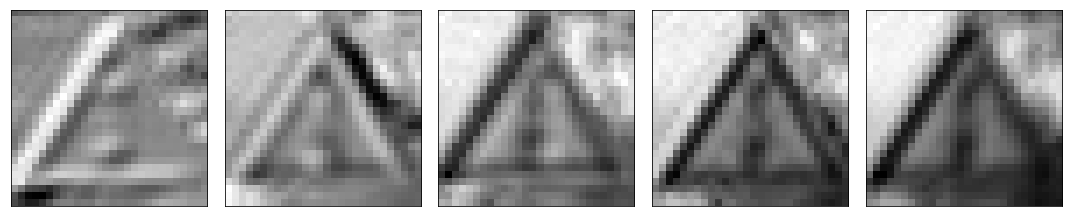

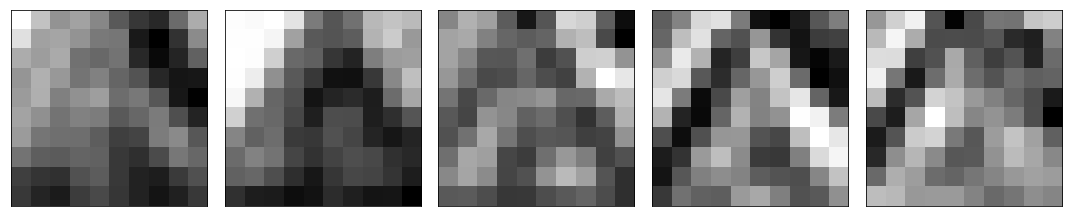

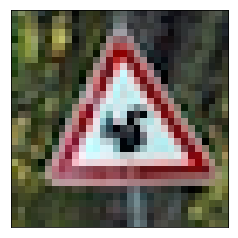

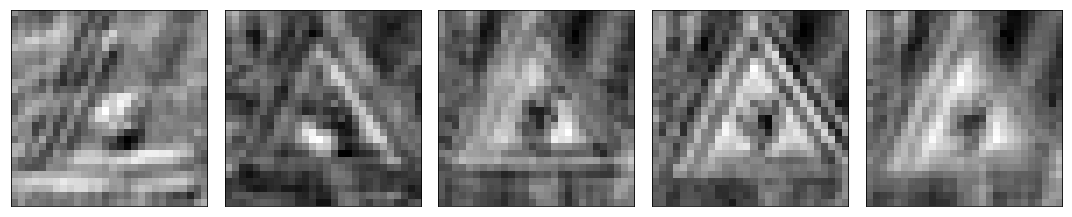

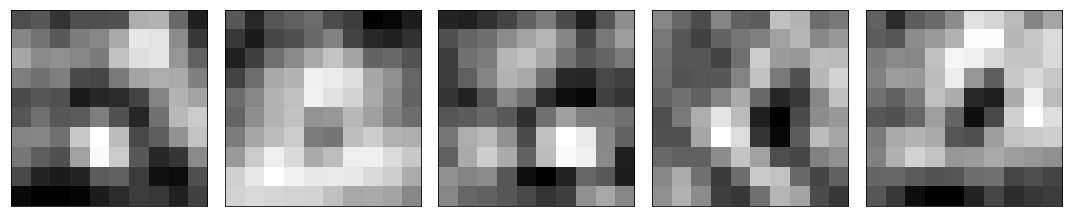

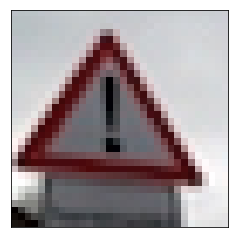

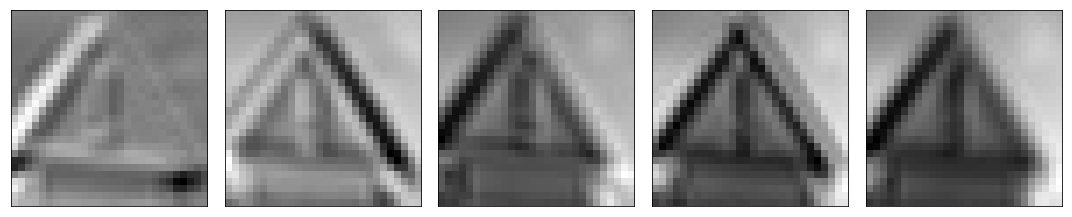

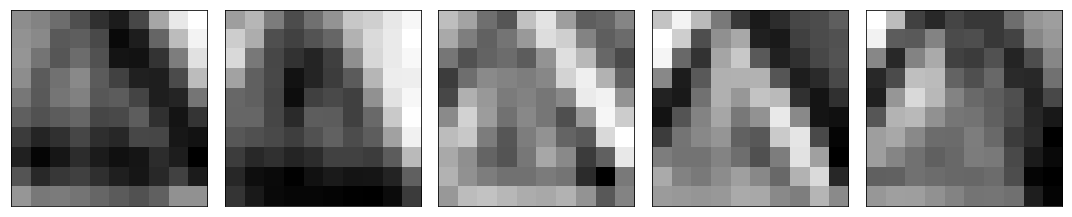

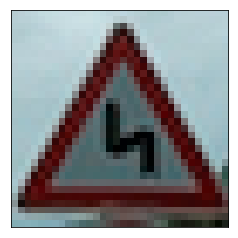

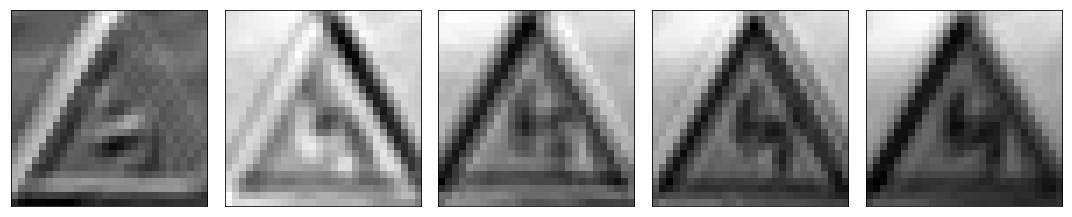

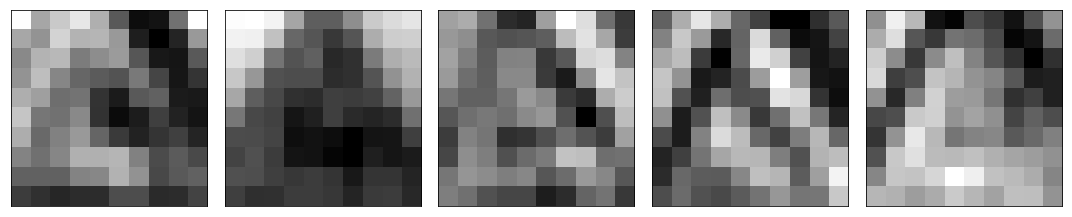

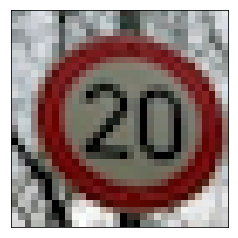

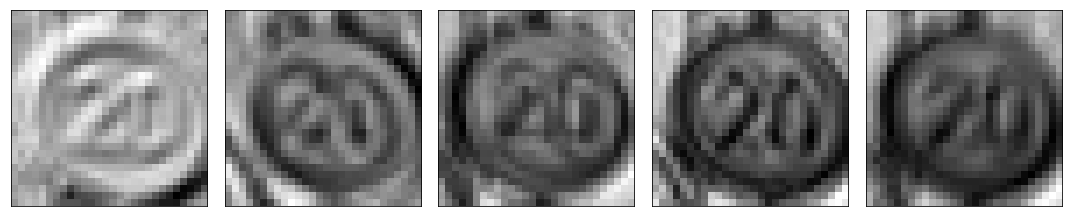

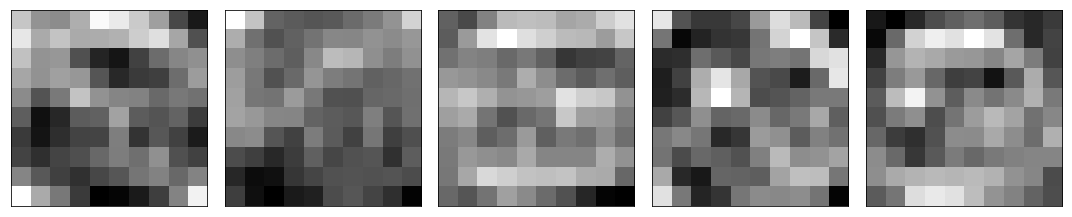

In [77]:
graph = tf.Graph()
with graph.as_default():
    tf_x = tf.placeholder(tf.float32, shape = (None, 32, 32, CHANNELS))
    keep_prob = tf.placeholder(tf.float32)
    logits = model_pass(tf_x, keep_prob, channels = CHANNELS)

with tf.Session(graph = graph) as session:
    tf.train.Saver().restore(session, './lenet')    
    
    for image_index in range(5):        
        image_input = X_internet_processed[image_index][None,:,:,:]
        
        ax = plt.figure()
        plt.subplot(xticks=[], yticks=[])
        plt.imshow(X_internet[image_index], cmap = 'gray')

        activation_min = -1
        activation_max = -1

        ops = [op for op in session.graph.get_operations() if op.name.endswith('activation')]

        for tf_activation in [ ops[0].outputs[0], ops[1].outputs[0] ]:
            activation = tf_activation.eval(
                feed_dict = {
                    tf_x: image_input,
                    keep_prob: 1.0
                },
                session = session
            )
            num_feature_maps = activation.shape[3]
            plt.figure(figsize=(15, 10))
            indexes = random.sample(range(num_feature_maps), 5)
            for feature_map_index in range(len(indexes)):
                plt.subplot(1, 5, feature_map_index + 1, xticks=[], yticks=[])
                fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.0, wspace = 0.0)
                if activation_min != -1 & activation_max != -1:
                    plt.imshow(activation[0,:,:, feature_map_index], interpolation="nearest", vmin=activation_min, vmax=activation_max, cmap="gray")
                elif activation_max != -1:
                    plt.imshow(activation[0,:,:, feature_map_index], interpolation="nearest", vmax=activation_max, cmap="gray")
                elif activation_min !=-1:
                    plt.imshow(activation[0,:,:, feature_map_index], interpolation="nearest", vmin=activation_min, cmap="gray")
                else:
                    plt.imshow(activation[0,:,:, feature_map_index], interpolation="nearest", cmap="gray")
                plt.tight_layout()

## Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images

**Answer:**

In my plots of the feature maps, I showed 5 randomly selected feature maps from both of my convolutional layers, next to the image that triggered these activations. It's clear from the first set of feature maps that the feature maps somewhat resemble the image causing the activations --- the feature maps are selecting significant parts of the input image. The second, lower resolution feature maps are less obvious in what they show.

Also, perhaps unsurprisingly, the image whose category did not appear in the training set has feature maps that least resemble the input image (60 km/h had 7x more training images than 20 km/h). Balancing the data set may have helped this.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 